In [30]:
import os
import pickle
import numpy as np
import tensorflow as tf
import re
import matplotlib.pyplot as plt
import random 
from PIL import Image
from tqdm.notebook import tqdm
from nltk.translate.bleu_score import corpus_bleu
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, BatchNormalization, LayerNormalization


In [2]:
# Set the GPU device
physical_devices = tf.config.list_physical_devices('GPU')
print(f"GPUs detected: {len(physical_devices)}")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPUs detected: 1


In [3]:
model = ResNet50() 
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [4]:
def extract_features():
    features = {}
    img_dir = os.path.join(os.getcwd(), 'Images')

    for img_name in tqdm(os.listdir(img_dir)):
        img_path = os.path.join(img_dir, img_name)
        img = load_img(img_path, target_size=(224, 224))

        img = img_to_array(img)
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)

        feature = model.predict(img, verbose=0)

        img_id = img_name.split('.')[0]
        features[img_id] = feature

    pickle.dump(features, open('features.pkl', 'wb'))

    return features

In [5]:
if 'features.pkl' in os.listdir(os.getcwd()):
    print("Loading features from pickle file...")
    features = pickle.load(open('features.pkl', 'rb'))
else:
    print("Extracting features from images...")
    features = extract_features()
print(f"Loaded {len(features)} features 😮")

Loading features from pickle file...


Loaded 8091 features 😮


In [6]:
with open(os.path.join(os.getcwd(), 'captions.txt'), 'r') as f:
    # Skip the first line
    next(f)
    captions = f.readlines()

mapping = {}
for line in tqdm(captions):
    tokens = line.split(',')
    img_id, caption = tokens[0].split('.')[0], tokens[1]

    if img_id not in mapping:
        mapping[img_id] = []
    mapping[img_id].append(caption.split(' .\n')[0])

  0%|          | 0/40455 [00:00<?, ?it/s]

In [7]:
def rm_non_alpha(sentence):
    sentence = re.sub(r'[^A-Za-z]', ' ', sentence)

    return sentence

def rm_extra_space(sentence):
    sentence = re.sub(r'\s+', ' ', sentence.strip())
    return sentence

def rm_single_char(sentence):
    sentence = " ".join([word for word in sentence.split() if len(word) > 1])
    return sentence

def sanitize(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]

            caption = caption.lower()
            caption = rm_non_alpha(caption)
            caption = rm_extra_space(caption)
            caption = rm_single_char(caption)

            caption = '<start> ' + caption + ' <end>'
            captions[i] = caption

In [8]:
sanitize(mapping)

In [9]:
all_captions = []
for key, captions in mapping.items():
    for caption in captions:
        all_captions.append(caption)

In [10]:
# Allow only the top_k words in the vocabulary
top_k = 5000

tokenizer = Tokenizer(num_words=top_k, oov_token='<unk>', filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ') 
tokenizer.fit_on_texts(all_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

vocab_size = len(tokenizer.word_index) + 1
print(f"Vocab size: {vocab_size}")

Vocab size: 8262


In [11]:
max_length = max([len(caption.split()) for caption in all_captions])
print(f"Max length: {max_length}")

Max length: 31


In [12]:
X_train, X_test = train_test_split(list(mapping.keys()), test_size=0.1, random_state=42)
print(f"Training on {len(X_train)} images and testing on {len(X_test)} images")

Training on 7281 images and testing on 810 images


In [13]:
tokenizer.index_word

{1: '<unk>',
 2: '<start>',
 3: '<end>',
 4: 'in',
 5: 'the',
 6: 'on',
 7: 'is',
 8: 'and',
 9: 'dog',
 10: 'with',
 11: 'man',
 12: 'of',
 13: 'two',
 14: 'white',
 15: 'black',
 16: 'boy',
 17: 'are',
 18: 'woman',
 19: 'girl',
 20: 'to',
 21: 'wearing',
 22: 'people',
 23: 'at',
 24: 'water',
 25: 'young',
 26: 'red',
 27: 'brown',
 28: 'an',
 29: 'his',
 30: 'blue',
 31: 'dogs',
 32: 'running',
 33: 'through',
 34: 'playing',
 35: 'shirt',
 36: 'while',
 37: 'down',
 38: 'little',
 39: 'standing',
 40: 'ball',
 41: 'grass',
 42: 'person',
 43: 'child',
 44: 'snow',
 45: 'jumping',
 46: 'over',
 47: 'three',
 48: 'front',
 49: 'sitting',
 50: 'small',
 51: 'up',
 52: 'field',
 53: 'holding',
 54: 'large',
 55: 'group',
 56: 'by',
 57: 'green',
 58: 'yellow',
 59: 'children',
 60: 'walking',
 61: 'men',
 62: 'her',
 63: 'into',
 64: 'beach',
 65: 'air',
 66: 'near',
 67: 'jumps',
 68: 'mouth',
 69: 'street',
 70: 'runs',
 71: 'for',
 72: 'another',
 73: 'riding',
 74: 'from',
 75: '

In [14]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []
    n = 0

    while True:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = [], [], []
                n = 0

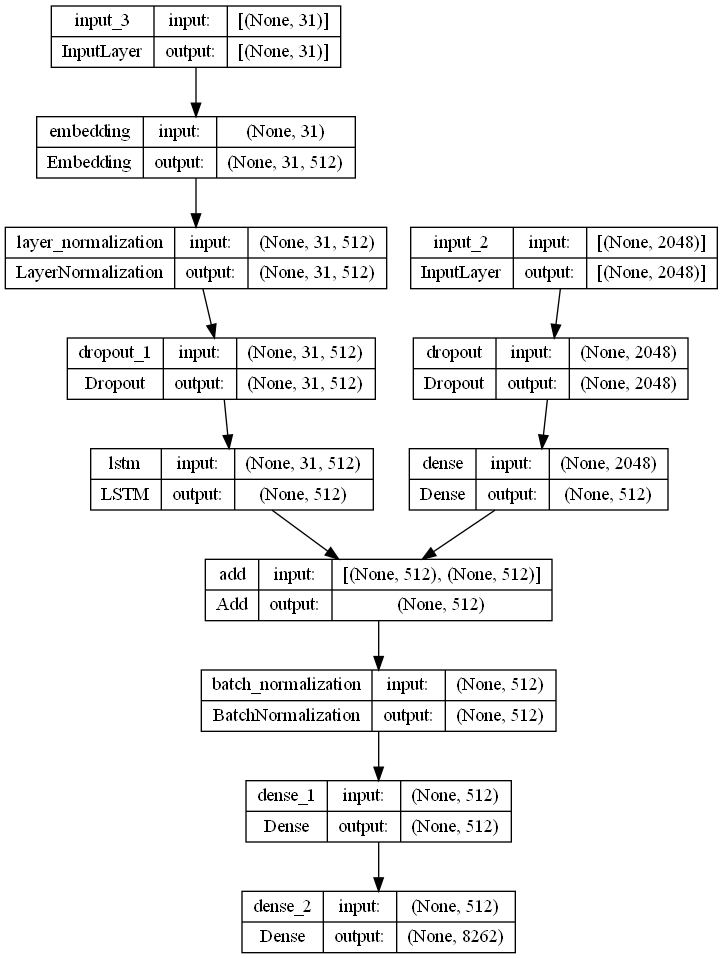

In [15]:
# Encoder model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(512, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 512, mask_zero=True)(inputs2)
se2 = LayerNormalization(epsilon=1e-6)(se1)
se3 = Dropout(0.4)(se2)
se4 = LSTM(512)(se3)

# Decoder model
decoder1 = add([fe2, se4])
decoder2 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
                              beta_initializer="zeros", gamma_initializer="ones",
                              moving_mean_initializer="zeros", moving_variance_initializer="ones",
                              beta_regularizer=None, gamma_regularizer=None, beta_constraint=None,
                              gamma_constraint=None)(decoder1)
decoder3 = Dense(512, activation='relu')(decoder2)
outputs = Dense(vocab_size, activation='softmax')(decoder3)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plot the model
plot_model(model, show_shapes=True)

In [18]:
epochs = 45 
batch_size = 32
steps = len(X_train) // batch_size
train_loss_history = []

os.makedirs('checkpoints', exist_ok=True)

for i in range(epochs):
    generator = data_generator(X_train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    
    history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    train_loss_history.append(history.history['loss'][0])

    checkpoint = f'model_{i + 1}_loss_{history.history["loss"][0]}.h5'
    model.save(os.path.join('checkpoints', checkpoint))

227/227 [==============================] - 98s 432ms/step - loss: 0.8131


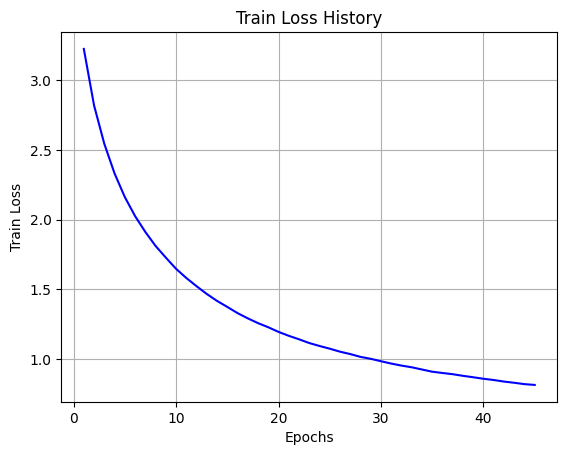

In [19]:
# Plot the training loss history
plt.plot(range(1, epochs+1), train_loss_history, 'b-')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('Train Loss History')
plt.grid(True)
plt.show()

In [20]:
checkpoints_dir = os.path.join(os.getcwd(), "checkpoints")
model_losses_mapping = {}

for file in os.listdir(checkpoints_dir):
    loss = (file.split("_")[-1]).split(".h5")[0]
    model_losses_mapping[file] = float(loss)

best_model = min(model_losses_mapping, key=model_losses_mapping.get)
model = load_model(os.path.join(checkpoints_dir, best_model))

for file in os.listdir(checkpoints_dir):
    if file != best_model:
        os.remove(os.path.join(checkpoints_dir, file))

print(f"Loaded {best_model}")

Loaded model_45_loss_0.8130692839622498.h5


In [21]:
def idx_to_word(yhat, tokenizer):
    for word, idx in tokenizer.word_index.items():
        if idx == yhat:
            return word
        
    return None

In [22]:
def greedy_search(model, img, tokenizer, max_length):
    in_text = '<start>'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        yhat = model.predict([img, sequence], verbose=0)
        yhat = np.argmax(yhat)

        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break

        in_text += ' ' + word
        if word == '<end>':
            break
    
    return in_text

In [23]:
def beam_search(model, img_features, tokenizer, max_length, beam_width=5):
    start_token = [tokenizer.word_index['<start>']]
    sequences = [[start_token, 0.0]]

    while len(sequences[0][0]) < max_length:
        candidates = []
        for seq in sequences:
            sequence = pad_sequences([seq[0]], maxlen=max_length).reshape((1,max_length))
            preds = model.predict([img_features.reshape(1,2048), sequence], verbose=0)

            word_preds = np.argsort(preds[0])[-beam_width:]

            for word in word_preds:
                next_cap, probs = seq[0][:], seq[1]
                next_cap.append(word)
                probs += preds[0][word]
                candidates.append([next_cap, probs])

        sequences = candidates
        sequences = sorted(candidates, reverse=False, key=lambda c: c[1])
        sequences = sequences[-beam_width:]


    sequences = sequences[-1][0]
    intermediate_caption = [idx_to_word(idx, tokenizer) for idx in sequences]

    final_caption = []
    for word in intermediate_caption:
        if word != '<end>':
            final_caption.append(word)
        else:
            break

    final_caption = '<start> ' + ' '.join(final_caption[1:]) + ' <end>'

    return final_caption, beam_width

In [24]:
def search_evaluation(flag, model, features, tokenizer, max_length, X_test, mapping):
    actual, predicted = [], []
    for key in tqdm(X_test):
        captions = mapping[key]

        if flag == 'greedy':
            y_pred = greedy_search(model, features[key], tokenizer, max_length)
        elif flag == 'beam':
            y_pred, _ = beam_search(model, features[key], tokenizer, max_length)

        actual_captions = [caption.split() for caption in captions]
        y_pred = y_pred.split()

        actual.append(actual_captions)
        predicted.append(y_pred)

    return actual, predicted

In [25]:
# Beam Search takes too long even with GPU acceleration, but is guaranteed to do better than Greedy Search
actual, predicted = search_evaluation('greedy', model, features, tokenizer, max_length, X_test, mapping)

  0%|          | 0/810 [00:00<?, ?it/s]

In [29]:
bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
bleu3 = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

print(f"BLEU-1: {bleu1}\nBLEU-2: {bleu2}\nBLEU-3: {bleu3}\nBLEU-4: {bleu4}")

BLEU-1: 0.52170071783545
BLEU-2: 0.29635354059896657
BLEU-3: 0.21266335498952105
BLEU-4: 0.10695267479557999


In [26]:
def generate_caption(img_name):
    img_id = img_name.split('.')[0]
    img_path = os.path.join(os.getcwd(), 'Images', img_name)
    img = load_img(img_path, target_size=(224, 224))

    print('---------------------Actual---------------------')
    captions = mapping[img_id]
    for caption in captions:
        print(caption)

    print('--------------------Predicted--------------------')
    greed = greedy_search(model, features[img_id], tokenizer, max_length)
    print(f'Greedy Search: {greed}')

    beam, n = beam_search(model, features[img_id], tokenizer, max_length)
    print(f'Beam Search n={n}: {beam}')

    plt.imshow(img)

Image: 3249891130_b241591e89.jpg

---------------------Actual---------------------
<start> group of chinese teenage girls walking <end>
<start> group of dark haired girls are walking together <end>
<start> group of dark haired young ladies in shorts walks past bank of lockers <end>
<start> four asian girls are walking through locker room <end>
<start> four dark haired girls walk the hall toward bank of lockers <end>
--------------------Predicted--------------------
Greedy Search: <start> four young men are standing on sidewalk with shirts <end>
Beam Search n=5: <start> four dark haired girls walk the hall toward bank of lockers <end>


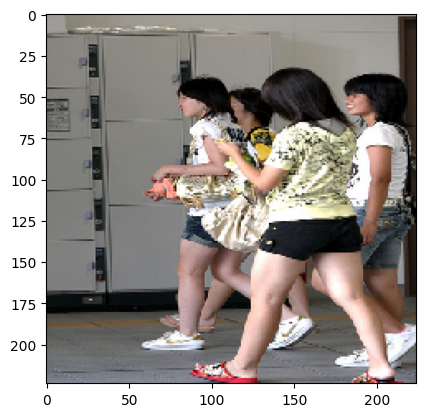

In [32]:
# Randomly select an image
random_img = random.choice(os.listdir(os.path.join(os.getcwd(), 'Images')))
print(f"Image: {random_img}\n")
generate_caption(random_img)